In [90]:
import torch
import transformers
import IPython
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
import umap
import pandas as pd
import numpy as np
import umap.plot

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import ast
import copy
from umap import UMAP

import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.cluster import KMeans

## Explore the whisper encoder embedding space 

### Explore the difference between noise and noise by whisper's UMAP reduced perception

In [4]:
# Prepare the voice data
# select samples of noise and 10 samples of voice
load_processed_dataset = True
n_samples = 300 

## Load model and datasets

In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-base")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base", torch_dtype=torch.bfloat16).to("cuda")

### For the datasets we will be using:
- google_fleurs: Multilingual dataset, which we will get a set of pt-BR samples
- Myrtle/CAIMAN-ASR-BackgroundNoise: dataset with only noises that do not have voice mixed in the samples

In [ ]:
if load_processed_dataset == False:
    ds = load_dataset("google/fleurs", "pt_br", split="train", streaming=True)
    noise_ds = load_dataset("Myrtle/CAIMAN-ASR-BackgroundNoise")

/home/rodrigo/miniconda3/envs/whisper/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
if load_processed_dataset == False:
    voice_meta_df = []
    keys_to_extract = ["transcription", "raw_transcription", "gender", "language"]

    for i, j in zip(range(n_samples), ds):
        if i >= n_samples:
            break

        subset_dict = pd.DataFrame(dict((key, [j[key]]) for key in keys_to_extract))
        subset_dict["sample_id"] = i
        subset_dict["array"] = [j["audio"]["array"]]
        voice_meta_df.append(subset_dict)

    voice_meta_df = pd.concat(voice_meta_df)
    voice_meta_df["type"] = "voice"


    # Prepare the noise data
    noise_samples = noise_ds["train"][:n_samples]
    noise_df = pd.DataFrame({"type" : ["noise"] * n_samples, 
                            "sample_id" : list(range(n_samples,n_samples + n_samples)), 
                            "array": [i["array"] for i in noise_samples["audio"]]})
    meta_df_all = pd.concat([voice_meta_df, noise_df]).reset_index()

In [6]:
# Definitions to help us to generate the embeddings in a batch
# even using a RTX 4060 I need to set 50 as batch size to not overload the graphics card VRAM
def get_output_batch(features, model):
    features = features.to(device="cuda", dtype=torch.bfloat16)
    output = model.model.encoder(**features, output_hidden_states=True).last_hidden_state.to("cpu", dtype=torch.float16).detach().numpy()
    features = features.to(device="cpu", dtype=torch.bfloat16)
    torch.cuda.empty_cache()

    return output

def get_output_batch_per_batch(feat_array, model, batch_size=50):
    n_batch = int(np.ceil(len(feat_array) / batch_size))
    all_features = []
    
    for batch in list(range(n_batch)):
        start_batch = int(batch * batch_size)
        end_batch = int((batch + 1) * batch_size)
        batch_feat = feat_array[start_batch: end_batch]
        batch_feat = processor(batch_feat, sampling_rate=16000, return_tensors="pt", return_attention_mask=True)
        all_features.append(get_output_batch(batch_feat, model))
    
    all_embeddings = np.concatenate(all_features, axis=0)
    return all_embeddings

### Generate the embeddings and reshape the tensor
Whisper encoder output is in the shape (batch, timestamps, features)

In [7]:
if load_processed_dataset == False:
    all_embeddings = get_output_batch_per_batch(meta_df_all["array"].to_list(), model)
    all_embeddings = all_embeddings.reshape((all_embeddings.shape[0], int(all_embeddings.shape[1] * all_embeddings.shape[2])))
    meta_df_all["whisper_embeddings"] = [i for i in all_embeddings]
    meta_df_all.to_csv("noise_analisys_data.tsv", sep="\t")
else:
    meta_df_all.read_csv("noise_analisys_data.tsv", sep="\t")
    meta_df_all["array"] = meta_df_all.apply(lambda x: ast.literal_eval(x))
    meta_df_all["whisper_embeddings"] = meta_df_all.apply(lambda x: ast.literal_eval(x))


In [16]:
meta_df_all

,index,transcription,raw_transcription,gender,language,sample_id,array,type,whisper_embeddings
0,0,o governo anterior considerado conservador da ...,"O governo anterior, considerado conservador, d...",0.0,Portuguese,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-1.25, -0.063, -0.3184, -1.219, 0.2617, -1.31..."
1,0,alguns dos aplicativos desta categoria podem i...,Alguns dos aplicativos desta categoria podem i...,0.0,Portuguese,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-1.1875, 0.1592, -0.5195, -1.523, 0.124, -0.1..."
2,0,o ônibus da banda estava seguindo para o six f...,O ônibus da banda estava seguindo para o Six F...,0.0,Portuguese,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-1.398, 0.252, -0.3477, -1.461, 0.168, -0.59,..."
3,0,por alguns trocados algumas crianças lhe conta...,"Por alguns trocados, algumas crianças lhe cont...",1.0,Portuguese,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-0.8047, 0.10156, 0.5547, -0.2559, -0.957, -1..."
4,0,esta é uma prática comum em outras partes do r...,Esta é uma prática comum em outras partes do R...,1.0,Portuguese,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-0.4707, -0.789, -0.003433, -1.625, -0.1875, ..."
...,...,...,...,...,...,...,...,...,...
595,295,NaN,NaN,NaN,NaN,595,"[-0.00604248046875, -0.01434326171875, -0.0137...",noise,"[-0.926, -0.00232, -0.2471, -1.508, 0.3242, -2..."
596,296,NaN,NaN,NaN,NaN,596,"[0.01971435546875, 0.033355712890625, 0.030090...",noise,"[-0.668, -0.4082, -0.633, -1.445, 1.32, -1.078..."
597,297,NaN,NaN,NaN,NaN,597,"[-0.277679443359375, -0.444793701171875, -0.36...",noise,"[-0.3906, -0.2676, -1.016, -1.805, 1.258, -1.2..."
598,298,NaN,NaN,NaN,NaN,598,"[0.003631591796875, -0.00146484375, -0.0053405...",noise,"[0.4336, -0.551, -1.352, -0.7188, 0.2139, -2.4..."


### Create UMAP object with all embeddings
Now we will create a UMAP object to reduce the dimmension of our embeddings to 2, this way we will be able to cluster the embeddings and visualize the clusters in a easy way.

In [17]:
# Create UMAP obejct
fit = umap.UMAP()

# Fits based in all embeddings
u = fit.fit(all_embeddings)
u_embeddings = u.transform(all_embeddings)
u_embeddings = u_embeddings.astype(np.double)

/home/rodrigo/miniconda3/envs/whisper/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rodrigo/miniconda3/envs/whisper/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Visualization of the UMAP reduced version of Whisper embeddings
Now we will plot the embeddings and the acutal type of the audio, pure voice or noise.

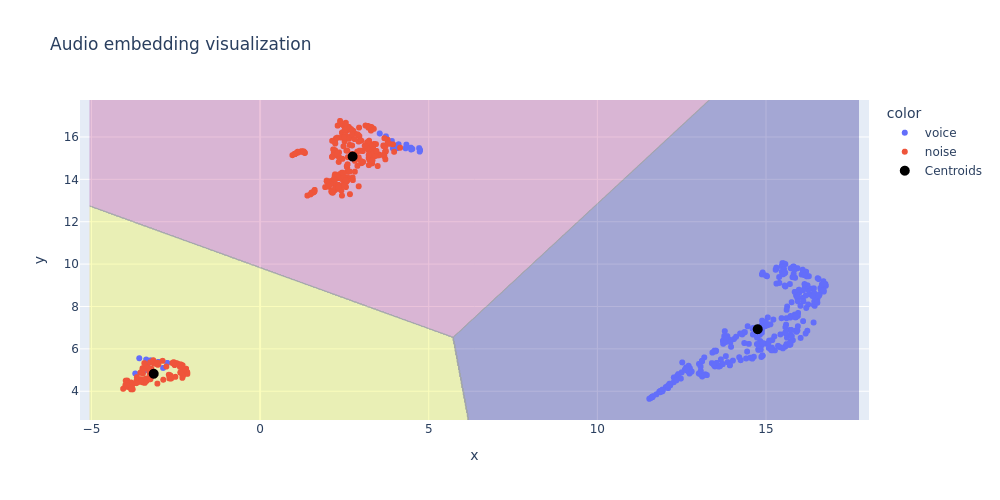

In [82]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(u_embeddings)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Create a scatter plot of the data points
fig = px.scatter(x=u_embeddings[:, 0], y=u_embeddings[:, 1], color=meta_df_all["type"], title="Audio embedding visualization")

# Add cluster centroids to the plot
fig.add_trace(go.Scatter(x=centroids[:, 0], y=centroids[:, 1], mode='markers', 
                         marker=dict(color='black', size=10, symbol='circle'), name='Centroids'))

# Create a mesh grid for plotting decision boundaries
x_min, x_max = u_embeddings[:, 0].min() - 1, u_embeddings[:, 0].max() + 1
y_min, y_max = u_embeddings[:, 1].min() - 1, u_embeddings[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict cluster labels for each point in the mesh grid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Add cluster boundaries to the plot
fig.add_trace(go.Contour(x=np.arange(x_min, x_max, 0.02), y=np.arange(y_min, y_max, 0.02), 
                         z=Z, showscale=False, opacity=0.3))

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
)

# Show the plot
fig.show("png")


### Based on the clusters it seems quite simple to classificate based on these UMAP embeddings
To check it out we will use SVM to classificate with the UMAP embedding reduction

In [91]:
# Create the SVM datasets
# y = np.zeros(int(n_samples*2), dtype=int)
# y[:n_samples] = y[:n_samples] + 1



# Split the dataset into a training set and a test set|
X_train, X_test, y_train, y_test = train_test_split(
    u_embeddings, meta_df_all.sample_id.to_list(), test_size=0.2, random_state=42
)
sample_id_test = copy.copy(y_test)
y_train = [0 if i < 300 else 1 for i in y_train]
y_test = [0 if i < 300 else 1 for i in y_test]

In [86]:
# Transformation with UMAP followed by classification with a linear SVM
umap = UMAP(random_state=456)
umap_pipeline = Pipeline([("svc", LinearSVC(random_state=0, tol=1e-5))])
umap_pipeline.fit(X_train, y_train)

Pipeline(steps=[('svc', LinearSVC(random_state=0, tol=1e-05))])

In [92]:
y_pred = umap_pipeline.predict(X_test)
error_x_array = np.stack([x for x, i, j in zip(X_test, y_pred, y_test) if i != j])
sample_id_error_list = [x for x, i, j in zip(sample_id_test, y_pred, y_test) if i != j]

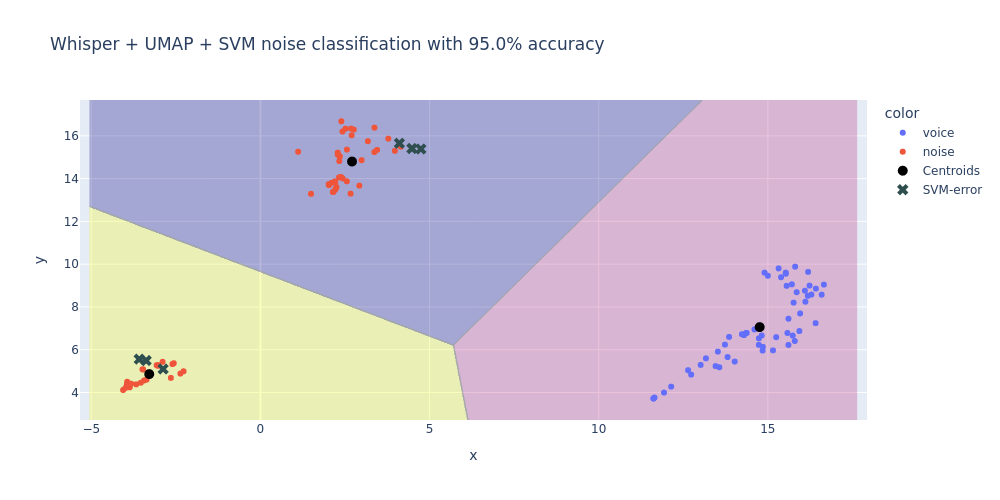

In [88]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_test)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

score = umap_pipeline.score(X_test, y_test) * 100

# Create a scatter plot of the data points
fig = px.scatter(x=X_test[:, 0], y=X_test[:, 1], color=["voice" if i == 0 else "noise" for i in y_test], title=f"Whisper + UMAP + SVM noise classification with {score}% accuracy")

# Add cluster centroids to the plot
fig.add_trace(go.Scatter(x=centroids[:, 0], y=centroids[:, 1], mode='markers', 
                         marker=dict(color='black', size=10, symbol='circle'), name='Centroids'))

# Add cluster centroids to the plot
fig.add_trace(go.Scatter(x=error_x_array[:, 0], y=error_x_array[:, 1], mode='markers', 
                         marker=dict(color='DarkSlateGrey', size=10, symbol='x'), name='SVM-error'))

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict cluster labels for each point in the mesh grid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Add cluster boundaries to the plot
fig.add_trace(go.Contour(x=np.arange(x_min, x_max, 0.02), y=np.arange(y_min, y_max, 0.02), 
                         z=Z, showscale=False, opacity=0.3))

fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
)

# Show the plot
fig.show("png")

#### Result analysis
Some voice samples ended up being inside the noise embedding cluster, which could mean that this voice sample has noise inside it or whisper encoder is not identifying it correctly. To test the both assumptions we will listen the audios and do an inference with whisper to check the performance. 

In [94]:
samples_dict = meta_df_all.loc[meta_df_all.sample_id.isin(sample_id_error_list)]
samples_dict

,index,transcription,raw_transcription,gender,language,sample_id,array,type,whisper_embeddings
6,0,hangeul é o único alfabeto inventado de propós...,Hangeul é o único alfabeto inventado de propós...,1.0,Portuguese,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-0.1699, -0.633, -0.02612, -0.965, -1.039, -1..."
118,0,a polícia disse que lo piccolo tinha a vantage...,A polícia disse que Lo Piccolo tinha a vantage...,1.0,Portuguese,118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-0.6797, -0.2988, 0.1777, -0.4258, 0.0349, -0..."
137,0,mas atualmente há artistas de grafite consagra...,"Mas, atualmente há artistas de grafite consagr...",1.0,Portuguese,137,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-0.535, -0.463, 0.332, -0.8633, -0.4453, -1.1..."
184,0,os passeios turísticos são caros exigem boa fo...,"Os passeios turísticos são caros, exigem boa f...",1.0,Portuguese,184,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-1.039, -0.785, -0.586, -1.398, 0.918, -0.992..."
199,0,os estados unidos falam que teriam recebido in...,Os Estados Unidos falam que teriam recebido in...,1.0,Portuguese,199,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-0.7383, -0.498, 0.2422, -1.242, -0.4043, -0...."
234,0,danius disse neste momento não estamos fazendo...,"Danius disse: ""Neste momento não estamos fazen...",0.0,Portuguese,234,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"[-1.203, 0.4902, -0.4531, -1.5625, 0.248, -0.2..."


In [96]:
IPython.display.Audio(samples_dict["array"].iloc[0], rate=16000)

In [13]:
# load model and processor
model.config.forced_decoder_ids = None

# load dummy dataset and read audio files

input_features = processor(samples_dict["array"].to_list(), sampling_rate=16000, return_tensors="pt").input_features 
input_features = input_features.to(device="cuda", dtype=torch.bfloat16)
# generate token ids
predicted_ids = model.generate(input_features).to("cuda")
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
torch.cuda.empty_cache()
samples_dict["whisper_transcription"] = transcription


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/tmp/ipykernel_5663/650666427.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [14]:
samples_dict

,index,transcription,raw_transcription,gender,language,sample_id,array,type,whisper_transcription
6,0,hangeul é o único alfabeto inventado de propós...,Hangeul é o único alfabeto inventado de propós...,1.0,Portuguese,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,R.G.U. é um único alfabeto inventado de propó...
16,0,a rm se baseia no fenômeno físico chamado ress...,A RM se baseia no fenômeno físico chamado ress...,1.0,Portuguese,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.9604644775390...",voice,A R.M. se basinha no fenômeno físico chamado ...
27,0,a civilização do vale do indo foi uma civiliza...,A Civilização do Vale do Indo foi uma civiliza...,1.0,Portuguese,27,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,A civilização do Vale do Indo foi uma civiliz...
53,0,raymond damadian médico e cientista pesquisado...,"Raymond Damadian, médico e cientista pesquisad...",1.0,Portuguese,53,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"High Monde da Mádia, Remédico e Sintista Pesq..."
54,0,a primeira-ministra em exercício julia gillard...,A Primeira-Ministra em exercício Julia Gillard...,1.0,Portuguese,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"A primeira ministra em Execício, Julia, de La..."
61,0,o canionismo combina elementos de natação esca...,"O canionismo combina elementos de natação, esc...",1.0,Portuguese,61,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",voice,"O quenionismo combina elementos de natação, e..."
96,0,já comunicando em inglês e japonês a organizaç...,"Já comunicando em inglês e japonês, a organiza...",1.0,Portuguese,96,"[0.0, -5.960464477539063e-08, -2.3841857910156...",voice,"Já comunicando inglês e japonês, a organizaçã..."


### Check whisper output when subject to only noise 

In [18]:
sample_id_check_list = list(range(n_samples,n_samples + n_samples, 50))
samples_dict = meta_df_all.loc[meta_df_all.sample_id.isin(sample_id_check_list)]
samples_dict

,index,transcription,raw_transcription,gender,language,sample_id,array,type
300,0,NaN,NaN,NaN,NaN,300,"[-0.17913818359375, -0.26080322265625, -0.1835...",noise
350,50,NaN,NaN,NaN,NaN,350,"[0.022003173828125, 0.029327392578125, 0.01272...",noise
400,100,NaN,NaN,NaN,NaN,400,"[0.0003662109375, -0.001495361328125, -0.00033...",noise
450,150,NaN,NaN,NaN,NaN,450,"[0.03118896484375, -0.1099853515625, -0.232818...",noise
500,200,NaN,NaN,NaN,NaN,500,"[0.0362548828125, 0.08355712890625, 0.09548950...",noise
550,250,NaN,NaN,NaN,NaN,550,"[0.0, 3.0517578125e-05, 0.0, 3.0517578125e-05,...",noise


In [19]:
# load model and processor
model.config.forced_decoder_ids = None

# load dummy dataset and read audio files

input_features = processor(samples_dict["array"].to_list(), sampling_rate=16000, return_tensors="pt").input_features 
input_features = input_features.to(device="cuda", dtype=torch.bfloat16)
# generate token ids
predicted_ids = model.generate(input_features).to("cuda")
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
torch.cuda.empty_cache()
samples_dict["whisper_transcription"] = transcription

/tmp/ipykernel_5663/3033580925.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_dict["whisper_transcription"] = transcription


In [20]:
samples_dict

,index,transcription,raw_transcription,gender,language,sample_id,array,type,whisper_transcription
300,0,NaN,NaN,NaN,NaN,300,"[-0.17913818359375, -0.26080322265625, -0.1835...",noise,1 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個 個...
350,50,NaN,NaN,NaN,NaN,350,"[0.022003173828125, 0.029327392578125, 0.01272...",noise,1.5%
400,100,NaN,NaN,NaN,NaN,400,"[0.0003662109375, -0.001495361328125, -0.00033...",noise,1.5% deur. 1.5% deur. 1.5% deur. 1.5% deur. 1...
450,150,NaN,NaN,NaN,NaN,450,"[0.03118896484375, -0.1099853515625, -0.232818...",noise,The
500,200,NaN,NaN,NaN,NaN,500,"[0.0362548828125, 0.08355712890625, 0.09548950...",noise,1.0-2.1
550,250,NaN,NaN,NaN,NaN,550,"[0.0, 3.0517578125e-05, 0.0, 3.0517578125e-05,...",noise,I'm not sure if I can get it.


Whisper model do not reacts very well when subjected to only noise audio, it generated hallucination transcriptions in 6 of 6 cases.

## Conclusions
- Even though the Whisper is generating hallucination, its embeddings are usefull for classification noise from human voice. Using a simple SVM we achieved 95% of accuracy, without any aditional tunning.
- This approach could be improved exploring encoders that were tunned for this specific purpose

TODO
- distinghish different human voices
- distinghish different phrases from the same human
- distinghish presense or not of noise
- LoRA whisper encoder to deal better with noise

explore:
- different embeddings
- statistical features